In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.8.1
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [6]:
%load_ext autoreload
%autoreload 2

# import common libraries
import numpy as np
import sys
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
import tqdm 
import timeit
import time
import pandas as pd
from math import floor

# import some detectron2 utilities
import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init
from utils import PNG_to_JSON
from utils import PNG_to_JSON
from utils import tools_3d
from Nucleus import coco_nucleus
from skimage import io
import networkx as nx


0.4
Nucleus
utils.PNG_to_JSON


In [7]:
ROOT_PATH = "./test_3D/" 

NUCLEAR_Ch = 0 # zero-indexed => 0 corresponds to channel 1

#lists all images to be segmented should be in an img folder
images_to_segment = os.listdir(ROOT_PATH+"/img/")
images_to_segment = [name for name in images_to_segment if 'tif' in name]

print(images_to_segment)
print(len(images_to_segment))

['micropattern_3D_test.tif']
1


In [9]:
if not os.path.isdir(ROOT_PATH+"/masks/"):
    os.makedirs(ROOT_PATH+"/masks/")

input_img=images_to_segment[0]
print(input_img)
im = io.imread(ROOT_PATH+"img/"+input_img)
im = np.moveaxis(im, -1, 1)   #z, channel, x, y

print(im.shape) #verify shape always! It should be z, channels, x, y


micropattern_3D_test.tif
(43, 3, 256, 512)


In [10]:
#x and y should be multiple of 128, see 2D notebook

im = im[:,:,0:floor(im.shape[2]/128)*128,0:floor(im.shape[3]/128)*128]
print(im.shape)

(43, 3, 256, 512)
(43, 3, 256, 512)


In [11]:
# please modify model type and directory path to be used

model_type= 'invitro' # 'invitro'  or 'SC_sections'
model_path= '/nemo/lab/briscoej/home/shared/tiagu-models/micropatterns/'



for zim in range(0,len(images_to_segment)):
    
    input_img=images_to_segment[zim]
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 1)   #z, channel, x, y
    print(im.shape) #verify shape always!
    print(input_img)

    for z in range(im.shape[0]):
        print("Segmenting image:")
        print(z)

        sz=im[z,NUCLEAR_Ch,:,:] # im[z,:,:,0] #why this difference? tiff format?
        print(sz.shape)

        
        one = ImageInput(img_str=sz, step=128) 

        m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')


        print(np.shape(m_tiles[7].img))


        print("Predicting...")

        pred= detectron_init(model=model_type, model_dir=model_path) 

        tic=timeit.default_timer()
        print("Main_tiles")
        m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
        print("V_tiles")
        v_out = [detectron_predict(_im,pred) for _im in v_tiles]
        print("H_tiles")
        h_out = [detectron_predict(_im,pred) for _im in h_tiles]
        toc=timeit.default_timer()

        # Stitching
        print("Stitching...")
        tic=timeit.default_timer()
        test = Stitcher(one)
        seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=5)
        toc=timeit.default_timer()

        print(f'This image has {nuclei_tally} segmented nuclei.')



        # save mask 
        print("Saving...")
        im_seg = Image.fromarray(seg_mask)
        im_seg.save(ROOT_PATH+"masks/z"+f"{z:03d}"+"z_"+input_img)



micropattern_3D_test.tif
(43, 3, 256, 512)
micropattern_3D_test.tif
Segmenting image:
0
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 121 segmented nuclei.
Saving...
Segmenting image:
1
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 140 segmented nuclei.
Saving...
Segmenting image:
2
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 158 segmented nuclei.
Saving...
Segmenting image:
3
(256, 512)
Using step of 128px.
Splitting 

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 209 segmented nuclei.
Saving...
Segmenting image:
29
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 217 segmented nuclei.
Saving...
Segmenting image:
30
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 208 segmented nuclei.
Saving...
Segmenting image:
31
(256, 512)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 213 segmented nuclei.
Saving...
Segmenting image:
32
(256, 512)
Using st

micropattern_3D_test.tif
(43, 3, 256, 512)
micropattern_3D_test.tif
(43, 256, 512, 3)
(43, 256, 512, 0)
(43, 256, 512)
(43, 256, 512)
Saved npz with collection of 2D masks with small areas filtered out.
./test_3D/micropattern_3D_test.tif_masks_merge_no_small.npz
Number of labels: 1000
Done in 0.1 minutes
Total number of nuclei in the stack (connected components):
483
14.0
Percentage of nuclei too big:
40
Absolute number
195
Total number of nuclei in the stack:
483
Nuclei to split:
195
Total number of nuclei in the stack:
804
Nuclei to further split
2


Nuclei to further split
0




Total number of nuclei in the stack:
806


55
10.0
10.419354838709678
Took 0.089235 min
micropattern_3D_test.tif
(43, 256, 512, 3)
(43, 3, 256, 512)
(43, 256, 512)
Done in 0.1 minutes
Done!


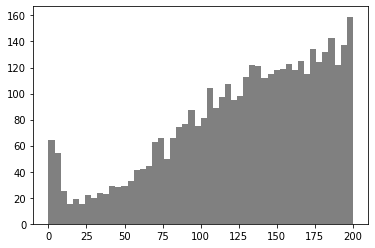

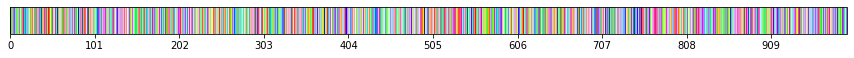

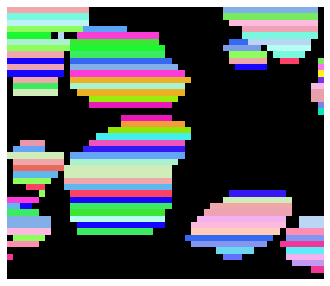

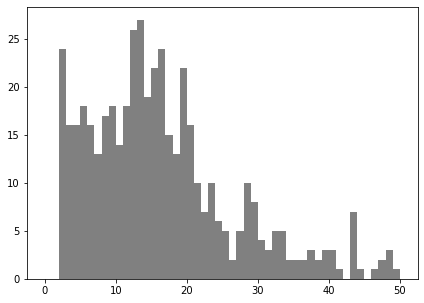

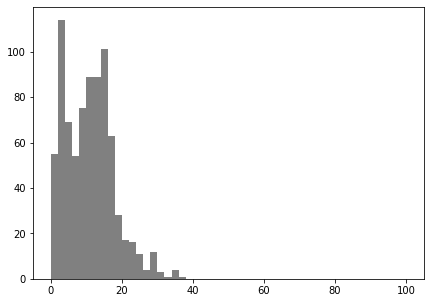

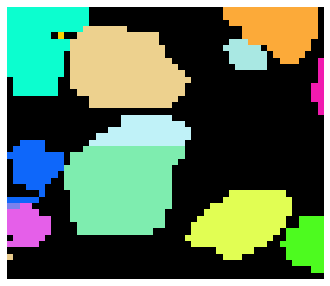

In [15]:
#select a soft and hard threshold above which to partition graph and put split nuclei into main dic (median+2 as a first pass?)
graph_par_thres = 16

hard_cutoff = 20 #nothing about graph_par_thres+hard_cutoff


cutoff = 50 # filter small 2D nuclei mask not to be considered when merging 3D models

for zim in range(0,len(images_to_segment)):
    
    input_img=images_to_segment[zim]
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 1)   #z, channel, x, y
    print(im.shape) #verify shape always!
    print(input_img)

    masks,df = tools_3d.make_3d_mask(ROOT_PATH, input_img, top_range=200) #histogram range 0-top


 
    masks = tools_3d.filter_and_save_3d_mask(masks, df, cutoff, ROOT_PATH, input_img)


    new_cmap = tools_3d.rand_cmap(1000, type='bright', first_color_black=True, last_color_black=False, verbose=True)
    
    plt.figure(figsize=(7,5))
    plt.imshow(np.flip(masks[:,200:250,150],axis=0), cmap=new_cmap, interpolation='none'); plt.axis('off')
    plt.figure(figsize=(7,5))


   # plt.figure(figsize=(15,15))
   # plt.imshow(np.flip(masks[:,700:850,350],axis=0), cmap=new_cmap, interpolation='none');


    #build a graph linking nuclei across z

    tic = time.perf_counter()
    to_add = tools_3d.graph_contructor(masks)
    G = nx.DiGraph()
    to_add2=[tuple(x[0]) for x in to_add if not x==[]]
    G.add_edges_from(to_add2)
    nx.write_gpickle(G, ROOT_PATH+input_img+"G.gpickle")
    toc = time.perf_counter()

    print(f"Done in {(toc - tic)/60:0.1f} minutes")


    G = nx.read_gpickle(ROOT_PATH+input_img+"G.gpickle")
    
    
    masks = np.load(ROOT_PATH+input_img+"_masks_merge_no_small.npz")
    masks = masks['arr_0']


    nuclei = tools_3d.graph_stats(G)





    nodes_per_nucleus = {}  
    for i in nuclei.keys():
        nodes_per_nucleus[i]=len(list(nuclei[i]))
    print("Percentage of nuclei too big:")
    print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()]) *100 / len(nodes_per_nucleus.values())))
    print("Absolute number")
    print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()])))




    
    nuclei = tools_3d.consolidate(G, masks, nuclei, graph_par_thres,hard_cutoff)


    nodes_per_nucleus = {}  
    for i in nuclei.keys():
        nodes_per_nucleus[i]=len(list(nuclei[i]))

    print(np.sum([x<2 for x in list(nodes_per_nucleus.values())]))
    
    plt.figure(figsize=(7,5))
    _ = plt.hist(nodes_per_nucleus.values(), 50, range=[0,100], facecolor='grey')
    print(np.median(list(nodes_per_nucleus.values())))
    print(np.mean(list(nodes_per_nucleus.values())))


    start = time.time()
    masks_3d = tools_3d.make_3d_mat(nuclei, masks)
    masks_3d = masks_3d.get()
    end = time.time()

    np.savez_compressed(ROOT_PATH+"mask_3d_"+input_img+".npz", masks_3d)

    print("Took %f min" % ((end - start) / 60.0) )


    plt.figure(figsize=(7,5))
    plt.imshow(np.flip(masks_3d[:,200:250,150],axis=0), cmap=new_cmap, interpolation='none'); plt.axis('off')


    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    print(im.shape) # should be (z, channels, x,y)
    im = np.moveaxis(im, -1, 1) #may need to be commented
    #im = im[:,:,0:floor(im.shape[2]/128)*128,0:floor(im.shape[3]/128)*128]
    print(im.shape)


    data = np.load(ROOT_PATH+"mask_3d_"+input_img+".npz")
    masks_3d = data['arr_0']
    print(masks_3d.shape)

    tic = time.perf_counter()
    result = tools_3d.get_feature_table(input_img, im, masks_3d)
    toc = time.perf_counter()
    print(f"Done in {(toc - tic)/60:0.1f} minutes")


    Data = pd.DataFrame(result, columns=('Image','Instance','Volume','Center Mass',
                                     'nuclear_avgs','hood_avgs','cyto_avgs',)
                       )

    output_table = ROOT_PATH + input_img + "_3D_nuclei_features_table.csv"
    Data.to_csv(output_table, index=False)
    Data

    print("Done!")

In [16]:
Data

,Image,Instance,Volume,Center Mass,nuclear_avgs,hood_avgs,cyto_avgs
0,micropattern_3D_test.tif,1,2306,"(2.0, 78.0, 321.0)","[90.652, 33.54, 7.925]","[71.749, 33.434, 8.961]","[50.414, 33.315, 10.13]"
1,micropattern_3D_test.tif,2,2887,"(4.0, 104.0, 313.0)","[91.469, 32.091, 40.321]","[67.049, 26.325, 29.826]","[41.914, 20.39, 19.023]"
2,micropattern_3D_test.tif,3,3289,"(6.0, 74.0, 283.0)","[89.08, 48.788, 32.357]","[69.257, 40.086, 25.316]","[47.371, 30.478, 17.542]"
3,micropattern_3D_test.tif,4,4452,"(6.0, 61.0, 320.0)","[99.402, 132.303, 10.127]","[74.219, 90.669, 9.476]","[47.144, 45.909, 8.776]"
4,micropattern_3D_test.tif,5,3590,"(4.0, 44.0, 349.0)","[92.252, 42.902, 7.046]","[67.47, 33.606, 6.852]","[41.586, 23.896, 6.649]"
...,...,...,...,...,...,...,...
801,micropattern_3D_test.tif,802,387,"(36.0, 181.0, 317.0)","[103.318, 40.008, 26.377]","[89.629, 36.446, 26.256]","[84.957, 35.23, 26.214]"
802,micropattern_3D_test.tif,803,7670,"(30.0, 140.0, 334.0)","[127.793, 39.441, 48.471]","[110.711, 39.408, 39.527]","[97.689, 39.382, 32.708]"
803,micropattern_3D_test.tif,804,7483,"(9.0, 127.0, 341.0)","[122.849, 51.453, 56.454]","[109.024, 44.548, 47.684]","[92.268, 36.178, 37.054]"
804,micropattern_3D_test.tif,805,5605,"(16.0, 137.0, 213.0)","[99.981, 77.867, 28.164]","[72.145, 55.5, 22.087]","[50.092, 37.78, 17.273]"


Text(0.5, 1.0, 'Volume (px)')

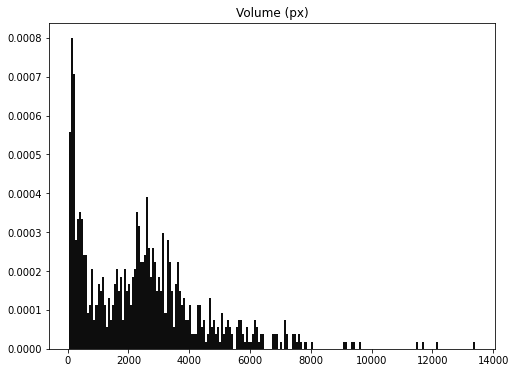

In [18]:
plt.figure(figsize=(8,6))
plt.hist(Data['Volume'], 200, density=True, facecolor='black', alpha=0.95)
plt.title('Volume (px)')
#plt.xlim(0,15000)

In [17]:
tools_3d.export_3d_array_rgb(masks_3d, ROOT_PATH+input_img+'masks_colorful_paper.tif')

(43, 256, 512)

Unique nuclei ids in image:
807
dimensions: (43, 256, 512, 3)
exported rgb tif file to ./test_3D/micropattern_3D_test.tifmasks_colorful_paper.tif
done!
